In [1]:
from qiskit import *
from qiskit.quantum_info import *
from qiskit.visualization import *
import numpy as np


In [41]:
import sympy

In [2]:
def euclid_gcd(a,b):
    if a==0:
        return b
    return euclid_gcd(b%a,a)

RSA 

In [71]:
def get_decrypt_key(e, phi):
    d = 0
    x1 = 0
    x2 = 1
    y1 = 1
    temp_phi = phi

    while e > 0:
        temp1 = temp_phi//e
        temp2 = temp_phi - temp1 * e
        temp_phi = e
        e = temp2

        x = x2- temp1* x1
        y = d - temp1 * y1

        x2 = x1
        x1 = x
        d = y1
        y1 = y
        
    if temp_phi == 1:
        return d + phi

In [76]:
def encrypt(pk, plaintext):
    key, n = pk
    cipher = [(ord(char) ** key) % n for char in plaintext]
    return cipher


def decrypt(pk, ciphertext):
    key, n = pk
    plain = [chr((char ** key) % n) for char in ciphertext]
    return ''.join(plain)

In [279]:
p = sympy.randprime(0, 100)
q = sympy.randprime(0, 100)
# p = 3
# q = 5
N = p*q
phi = (p-1) * (q-1)
e = np.random.randint(2,phi)

g = euclid_gcd(e,phi)
while g != 1:
    e = np.random.randint(2,phi)
    g = euclid_gcd(e,phi)



In [280]:
message = "Text"
d = get_decrypt_key(e,phi)

In [281]:
print(N,e,phi,p,q,d) # (e,N) - public key pair; (d,N) - private key pair
public = (e,N)
private = (d,N)

287 193 240 7 41 337


In [282]:
encrypted_msg = encrypt(public, message)
encrypted_msg

[238, 108, 120, 53]

In [283]:
decrypted_msg=decrypt(private,encrypted_msg)
decrypted_msg

'Text'

In [284]:

n_qubits = 4 #dynamic qubit system
# binary = bin(N)[2:]
# print(len(binary))
# n_qubits = len(binary) 

In [285]:
# np.random.seed(1) # This is to make sure we get reproduceable results
m = np.random.randint(2,N)
print(m)

81


if gcd == 1 then m and N are co prime else m is one of the trivial factors of N

In [286]:
calc_gcd = euclid_gcd(m,N)
while calc_gcd != 1:
    m = np.random.randint(2,N)
    calc_gcd = euclid_gcd(m,N)
    
print(m)
print("Co-prime found")


81
Co-prime found


find m^r mod N to find smallest 3 r > 0

In [251]:
def m_rmodN(m, power):
    U = QuantumCircuit(4)  
    for i in range(power):
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
        for q in range(4):
            U.x(q)
    
    U = U.to_gate()
    U.name = "%i^%i mod %i" % (m, power, N)
    c_U = U.control()
    return c_U

In [219]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for q in range(n//2):
        qc.swap(q,n-q-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)),m,j)
        qc.h(j)
    qc.name = "QFT Dagger"
    return qc

s is random integer between 0 and r-1 where resultant phase is just s/r

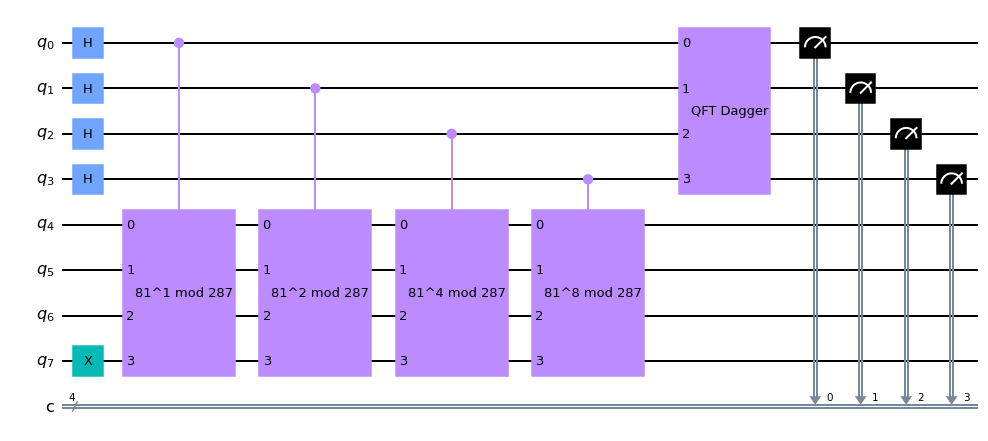

In [287]:
qc = QuantumCircuit(n_qubits + 4, n_qubits) # extra 4 qubits for U to act

for q in range(n_qubits):
    qc.h(q)
    
qc.x(3+n_qubits) # ancilla qubit to 1

#perform controlled U operations
for q in range(n_qubits):
    qc.append(m_rmodN(m, 2**q), [q]+[i+n_qubits for i in range(4)])

qc.append(qft_dagger(n_qubits),range(n_qubits))

qc.measure(range(n_qubits),range(n_qubits))

qc.draw('mpl')

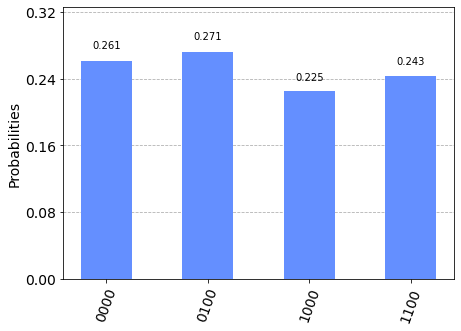

In [288]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=1024).result()
counts = results.get_counts()
plot_histogram(counts)

In [289]:
import pandas as pd
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_qubits)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_qubits} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

        Register Output         Phase
0  1000(bin) =   8(dec)   8/16 = 0.50
1  0000(bin) =   0(dec)   0/16 = 0.00
2  1100(bin) =  12(dec)  12/16 = 0.75
3  0100(bin) =   4(dec)   4/16 = 0.25


In [290]:
import fractions
rows = []
for phase in measured_phases:
    frac = fractions.Fraction(phase).limit_denominator(N)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.50      1/2            2
1   0.00      0/1            1
2   0.75      3/4            4
3   0.25      1/4            4


In [291]:
g_set = df["Guess for r"]
g_set = set(g_set)
g_set = list(g_set)
g_set

[1, 2, 4]

In [292]:
guesses = []
for r in range(len(g_set)):
    guesses.append([euclid_gcd(m**(r//2)-1, N), euclid_gcd(m**(r//2)+1, N)])

print(guesses)


[[287, 1], [287, 1], [1, 41]]


In [293]:
factors = []
for guess in guesses:
    if N%guess[0] == 0 and guess[0] not in [1,N]:
        print("Non Trivial Factor are below")
        print(guess[0])
        factors.append(guess[0])
    if N%guess[1]==0 and guess[1] not in [1,N]:
        print("Non Trivial Factor are below")
        print(guess[1])
        factors.append(guess[1])

Non Trivial Factor are below
41


In [294]:
if factors:
    print(factors)
if len(factors) == 0:
    print("There are no prime factors found")
    
elif len(factors) == 1:
    factors.append(N//factors[0])
    print("Factors are "+str(factors[0])+ " and "+ str(factors[1]))
elif len(factors) == 2:
    print("Factors are "+str(factors[0])+ " and "+ str(factors[1]))




[41]
Factors are 41 and 7


In [307]:
p,q = factors[0],factors[1]
phi_shor = (p-1) * (q-1)
dd = get_decrypt_key(e,phi_shor)
priv = (dd,N)
shor_decrypt=decrypt(priv,encrypted_msg)
if shor_decrypt == decrypted_msg:
    print("Broke it! using p and q values")
else:
    print("NO LUCK :(")

Broke it! using p and q values


In [308]:
p,q,d,dd

(41, 7, 337, 337)

In [301]:
shor_decrypt,decrypted_msg

('Text', 'Text')